In [2]:
import os
import sys
sys.path.append("../../")

from var_objective.equations import get_pdes
from var_objective.equations import get_pdes
from var_objective.grids import EquiPartGrid
from var_objective.generator import generate_fields
from var_objective.interpolate import estimate_fields
from var_objective.conditions import get_conditions_set
from var_objective.derivative_estimators import get_diff_engine,SplineDiff
import numpy as np
import matplotlib.pyplot as plt
import sympy
from scipy.interpolate import UnivariateSpline

In [3]:
seed = 0
np.random.seed(seed)

width = 4.0
noise_ratio = 0.2
freq = 20

In [4]:
oscillator = get_pdes("DrivenHarmonicOscillator")
observed_grid = EquiPartGrid([width], freq)
full_grid = EquiPartGrid([width],1000)

In [5]:
conditions = get_conditions_set('NumbersRandom2',params={'seed':seed,'num_samples':1})

In [6]:
ground_truth = generate_fields(oscillator, conditions, full_grid, 0.0, seed=seed)
observed_dataset = generate_fields(oscillator, conditions, observed_grid, noise_ratio, seed=seed)
t_observed = np.linspace(0,width,freq)
t_full = np.linspace(0,width,1000)

In [7]:
def get_solution(x0, dxdt0, order=0):
    k = 4.0
    d = 0.5
    k_r = 3.0
    F = 5.0
    denom = (2*d*k*k_r) ** 2 + (k ** 2 - k_r ** 2) ** 2
    partA =  - F * (2*d*k*k_r) / denom
    partB = F * (k ** 2 - k_r ** 2) / denom
    A = x0 - partA
    B = (dxdt0 - partB*k_r + A*d*k) / (k * np.sqrt(1-d**2))
    x = sympy.Symbol('x',real=True)
    traj = sympy.exp(-d*k*x) \
                *(A*sympy.cos(k*sympy.sqrt(1-d**2)*x) \
                + B*sympy.sin(k*sympy.sqrt(1-d**2)*x)) \
                + partA * sympy.cos(k_r*x) \
                + partB * sympy.sin(k_r*x)
    for i in range(order):
        traj = traj.diff()
    
    func = sympy.lambdify([x],traj,'numpy')
    return func

In [8]:
def plot_trajectory(ax,order=0):
    seed = 0
    np.random.seed(seed)

    width = 2.0
    noise_ratio = 0.1
    
    freq = 20
    
    algs = ['finite','spline','gp']
    display_names = {'finite':'Finite Difference', 'gp':'GP','spline':'Spline'}
    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
    cmap = {'gt':CB_color_cycle[0],'observed':CB_color_cycle[0],'finite':CB_color_cycle[1],'gp':CB_color_cycle[2],'spline':CB_color_cycle[3]}
    linewidth = 3
    
    oscillator = get_pdes("DrivenHarmonicOscillator")
    observed_grid = EquiPartGrid([width], freq)
    full_grid = EquiPartGrid([width],1000)
    
    conditions = get_conditions_set('NumbersRandom2',params={'seed':seed,'num_samples':1})
    x0, dxdt0 = conditions.get_condition_functions(0)
    
    ground_truth = generate_fields(oscillator, conditions, full_grid, 0.0, seed=seed)
    observed_dataset = generate_fields(oscillator, conditions, observed_grid, noise_ratio, seed=seed)
    t_observed = np.linspace(0,width,freq)
    t_full = np.linspace(0,width,1000)
    
    if order == 0:
        res = observed_dataset[0,0]
        ax.scatter(t_observed,res,label='Observed data',c=cmap['observed'])
        ax.plot(t_full, get_solution(x0,dxdt0,order=order)(t_full),label='Ground truth',c=cmap['gt'],linewidth=linewidth)
        us = UnivariateSpline(t_observed,res,s=0.01)
        est_spline = us(t_observed)
        ax.plot(t_observed,est_spline,label='Spline',c=cmap['spline'],linewidth=linewidth)
        estimated = estimate_fields(observed_grid,observed_dataset,observed_grid,seed=seed)
        ax.plot(t_observed,estimated[0,0],label='GP',c=cmap['gp'],linewidth=linewidth)
        
    else:
        ax.plot(t_full, get_solution(x0,dxdt0,order=order)(t_full),label='Ground truth',c=cmap['gt'],linewidth=linewidth)
        for alg in algs:
            res = observed_dataset[0,0]
            engine = get_diff_engine(alg)
            for i in range(order):
                res = engine.differentiate(res,observed_grid,0)
                
            gt_data = get_solution(x0,dxdt0,order=order)(t_observed)
            error = np.sqrt(np.mean((gt_data-res)**2))
            ax.plot(t_observed,res,label=display_names[alg],c=cmap[alg],linewidth=linewidth)

c:\Users\krkac\Miniconda3\envs\d-cipher\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


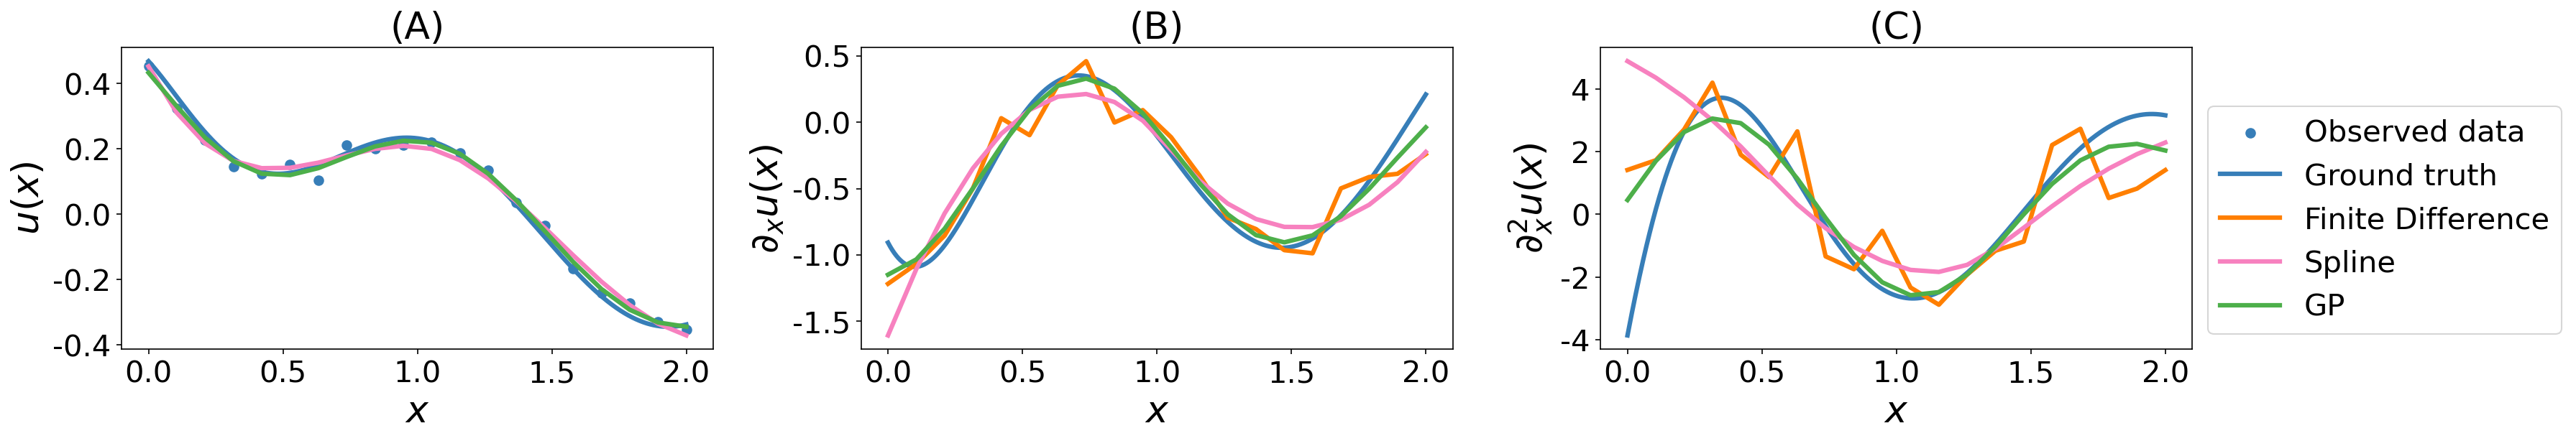

In [9]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

xlabel_fontsize = 25
ylabel_fontsize = 25
title_fontsize = 25
legend_fontsize = 20
ticks_fontsize = 20

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3,figsize=(24,4),dpi=150)

plot_trajectory(ax1,0)
ax1.set_xlabel(r'$x$', fontsize=xlabel_fontsize)
ax1.set_ylabel(r'$u(x)$', fontsize=ylabel_fontsize)
ax1.set_yticks([-0.4,-0.2,0.0,0.2,0.4])
ax1.set_yticklabels([-0.4,-0.2,0.0,0.2,0.4], fontsize=ticks_fontsize)
ax1.set_xticks([0.0,0.5,1.0,1.5,2.0])
ax1.set_xticklabels([0.0,0.5,1.0,1.5,2.0], fontsize=ticks_fontsize)
ax1.title.set_text("(A)")
ax1.title.set_fontsize(title_fontsize)


plot_trajectory(ax2,1)
ax2.set_xlabel(r'$x$', fontsize=xlabel_fontsize)
ax2.set_ylabel(r'$\partial_x u(x)$', fontsize=ylabel_fontsize)
ax2.set_yticks([-1.5,-1.0,-0.5,0.0,0.5])
ax2.set_yticklabels([-1.5,-1.0,-0.5,0.0,0.5], fontsize=ticks_fontsize)
ax2.set_xticks([0.0,0.5,1.0,1.5,2.0])
ax2.set_xticklabels([0.0,0.5,1.0,1.5,2.0], fontsize=ticks_fontsize)
ax2.title.set_text("(B)")
ax2.title.set_fontsize(title_fontsize)

plot_trajectory(ax3,2)
ax3.set_xlabel(r'$x$', fontsize=xlabel_fontsize)
ax3.set_ylabel(r'$\partial_x^2 u(x)$', fontsize=ylabel_fontsize)
ax3.set_yticks([-4,-2,0,2,4])
ax3.set_yticklabels([-4,-2,0,2,4], fontsize=ticks_fontsize)
ax3.set_xticks([0.0,0.5,1.0,1.5,2.0])
ax3.set_xticklabels([0.0,0.5,1.0,1.5,2.0], fontsize=ticks_fontsize)
ax3.title.set_text("(C)")
ax3.title.set_fontsize(title_fontsize)

# fig.text(0.29, 0.95, "Forced and damped harmonic oscillator", fontsize=title_fontsize)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1[:2] + handles2[1:]
labels = labels1[:2] + labels2[1:]
fig.legend(handles, labels,loc='center right',fontsize=legend_fontsize)

plt.subplots_adjust(left=0.05,
                    bottom=0.2, 
                    right=0.85, 
                    top=0.9, 
                    wspace=0.25, 
                    hspace=0.3)

plt.savefig('figures/Figure_10.pdf')
